## Creating context vectors

In [5]:
def categorical(values, distribution, length):
    assert len(values) == len(distribution)
    values = np.array(values)
    sample = np.random.multinomial(1, distribution, size=(length,))
    indices = np.argmax(sample, axis=1)
    return values[indices]

In [6]:
values = [5,6,7,120]
distribution = [0.2, 0.1, 0.4, 0.3]
categorical(values, distribution, length=7)

array([  6,   7, 120,   7,   5,   5,   7])

In [7]:
feature_config = {
    0: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    1: {
        'values': [1, 2],
        'distribution': [0.2, 0.8],
    },
    2: {
        'values': [1, 2, 3],
        'distribution': [ 0.6, 0.3, 0.1],
    },
    3: {
        'values': [1,2,3,4],
        'distribution': [0.1, 0.2, 0.3, 0.4],
    },
    
    4: {
        'values': [1,2,3,4,5],
        'distribution': [0.15, 0.2, 0.3, 0.2, 0.15],
    },
    5: {
        'values': [1,2],
        'distribution': [0.1, 0.9],
    },
    6: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    7: {
        'values': [1,2,3,4],
        'distribution': [0.25]*4,
    },
    8: {
        'values': [1,2,3,4],
        'distribution': [0.4, 0.3, 0.2, 0.1],
    },
    9: {
        'values': [1, 2,3,4,5,6,7,8,9,10,11],
        'distribution': [0.01, 0.03, 0.08, 0.12, 0.16, 0.20, 0.16, 0.12 ,0.08, 0.03, 0.01],
    },
}

In [8]:
contexts = np.zeros((TIME_POINTS, NUM_FEATURES))

for i in range(NUM_FEATURES):
    values = feature_config[i]['values']
    distribution = feature_config[i]['distribution']
    contexts[:, i] = categorical(values, distribution, length=TIME_POINTS)

In [9]:
contexts, contexts.shape

(array([[4., 2., 2., 4., 4.],
        [4., 2., 1., 3., 4.],
        [4., 1., 1., 3., 5.],
        ...,
        [2., 2., 1., 4., 2.],
        [1., 2., 1., 4., 3.],
        [2., 2., 1., 4., 5.]]),
 (10000, 5))

### Visualizing context features

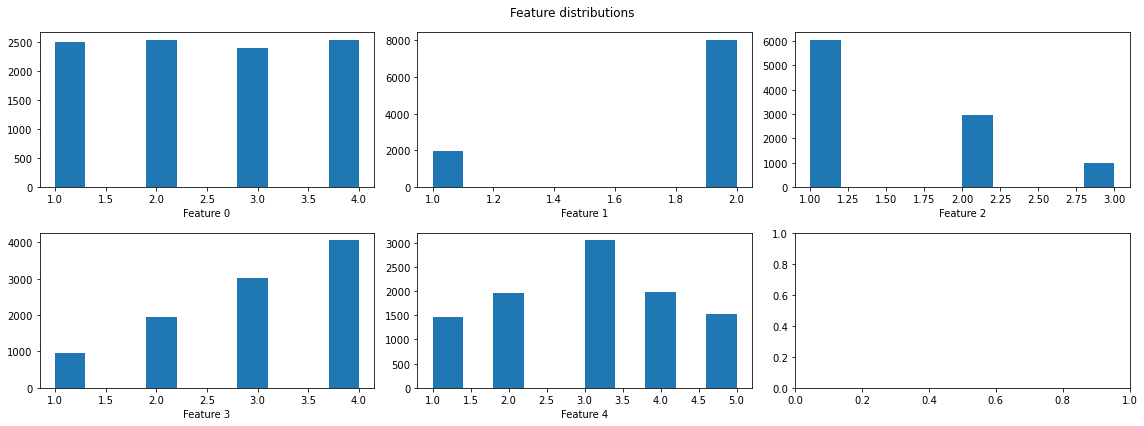

In [10]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

## Creating rewards

In [19]:
rewards = np.zeros((TIME_POINTS, N_ARMS))

In [20]:
slices = [
    slice(0,500),
    slice(500,1000),
    slice(1000,2000),
    slice(2000,4000),
    slice(4000,6000),
    slice(6000,8000),
    slice(8000,10000),
]

In [21]:
HIGH_REWARD_RANGE = [0.6, 0.99]
LOW_REWARD_RANGE = [0.01, 0.45]

In [22]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [23]:
# Here reward is stationary for given slice, arm.
# So piece-wise stationary for a given arm, not depending on context.

mean_rewards = np.zeros(rewards.shape)


for i, interval_slice in enumerate(slices):
    context_slice = contexts[interval_slice, :]
    slice_len = context_slice.shape[0]
    print(f"Slice {i}:")
    high_reward_arm = np.random.choice(N_ARMS)
    
    high_reward_arm = i % N_ARMS
    for arm in range(N_ARMS):

        # Use p from config (reward range is config)
        if arm == high_reward_arm:
            reward_range = HIGH_REWARD_RANGE
        else:
            reward_range = LOW_REWARD_RANGE
        
        p = np.random.uniform(reward_range[0], reward_range[1])

        # Sample rewards from the obtained distribution.
        slice_rewards = np.random.binomial(n=1, p=p, size=(slice_len,))
        rewards[interval_slice, arm] = slice_rewards
        
        # Check that thetas found by linear regression give estimation of expected reward close to
        # true expected reward. 
        
        # thetas found by solving linear regression problem
        linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)
        
        estimated_reward = np.mean(context_slice @ linreg_theta, axis=0)
        
        print(
            f"  Arm {arm}: p={np.mean(p):.2f}, mean reward={np.mean(slice_rewards):.2f}",
            f"  reward estimated by linear regression {estimated_reward:.2f}", 
        )
        
        # for visualization
        mean_rewards[interval_slice, arm] = np.ones(slice_rewards.shape) * np.mean(slice_rewards)

    

Slice 0:
  Arm 0: p=0.65, mean reward=0.64   reward estimated by linear regression 0.63
  Arm 1: p=0.25, mean reward=0.22   reward estimated by linear regression 0.22
  Arm 2: p=0.05, mean reward=0.06   reward estimated by linear regression 0.06
  Arm 3: p=0.39, mean reward=0.36   reward estimated by linear regression 0.35
  Arm 4: p=0.08, mean reward=0.07   reward estimated by linear regression 0.06
Slice 1:
  Arm 0: p=0.27, mean reward=0.28   reward estimated by linear regression 0.27
  Arm 1: p=0.70, mean reward=0.66   reward estimated by linear regression 0.65
  Arm 2: p=0.24, mean reward=0.22   reward estimated by linear regression 0.22
  Arm 3: p=0.30, mean reward=0.32   reward estimated by linear regression 0.31
  Arm 4: p=0.28, mean reward=0.26   reward estimated by linear regression 0.26
Slice 2:
  Arm 0: p=0.02, mean reward=0.02   reward estimated by linear regression 0.02
  Arm 1: p=0.11, mean reward=0.11   reward estimated by linear regression 0.10
  Arm 2: p=0.76, mean rew

/var/folders/_g/d2bwsxss6v9_1830lrh6wyth0000gn/T/ipykernel_44880/492892621.py:32: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  linreg_theta,res,rank,s = np.linalg.lstsq(a=context_slice, b=slice_rewards)


### Visualising rewards

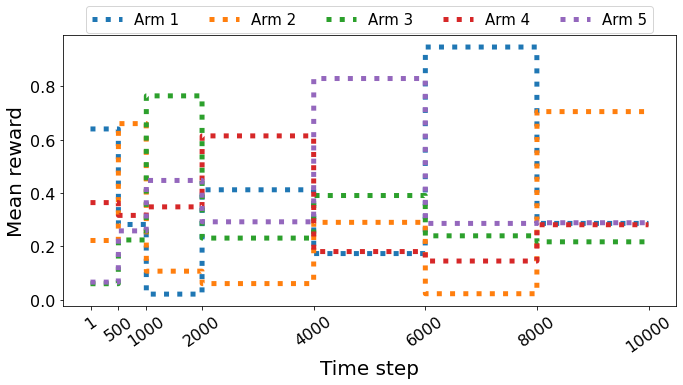

In [24]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    ax.plot(mean_rewards[:, arm], label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    

    
extraticks = [1, 500, 1000]
plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel('Mean reward', fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


### Additional analyses on the created synthetic dataset

This notebook loads data saved at the end of 1_synthetic_data_creation.ipynb.
Please run this only after running that notebook till the end.

In [ ]:
import os
os.chdir('../..')
os.getcwd()

In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import costs
import algorithms
import evaluation
from plotting.costs import plot_costs

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)

## Load the saved dataset

In [ ]:
import pickle

with open('dataset/synthetic/context_dependent.pickle', 'rb') as f:
    data = pickle.load(f)
    
contexts, rewards, costs_vector = data

In [ ]:
TIME_POINTS = contexts.shape[0]

In [53]:
NUM_FEATURES = contexts.shape[1]

In [ ]:
N_ARMS = rewards.shape[1]

In [ ]:
TIME_POINTS, NUM_FEATURES, N_ARMS

## Visualize contexts and rewards

In [ ]:
fig, axs = plt.subplots(2, math.ceil(NUM_FEATURES/2), figsize=(16,6))
for i, ax in zip(range(NUM_FEATURES), axs.flatten()):
    ax.hist(contexts[:, i])
    ax.set_xlabel(f"Feature {i}")
fig.suptitle('Feature distributions')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(N_ARMS):
    ax.plot(mean_rewards[:, arm], label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    

    
extraticks = [1, 500, 1000]
plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel('Mean reward', fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


In [ ]:
contexts.shape

In [25]:
rewards.shape

(10000, 5)

In [26]:
costs_vector.shape

(10000, 5)

## Calculating performance of contextual algorithms

We define the performance of an algorithm as the total
obtained rewards, i.e., the number of times that the optimal
action is chosen, divided by the total cost paid to observe
the features’ states.

We calculate performance for various cost ranges varying the upper border of the range of cost means.

In [29]:
NUM_OF_TRIALS = 10000

In [30]:
def get_costs_vector(max_cost_mean):
    # Mean of gaussian distribution random in interval [0, max_cost_mean] 
    interval_means = [np.random.uniform(0, max_cost_mean, size=(NUM_FEATURES,)) for i in range(5)]
    # Fixed std
    interval_stds = [[0.0005]*NUM_FEATURES]*5
    
    def get_costs():
        return costs.NonstationaryGaussianCosts(
            feature_vector_size=NUM_FEATURES,
            change_points=[3000, 4500, 5500, 8000],
            interval_means=interval_means,
            interval_stds=interval_stds,
            random_seed=42,
        )
    
#     fig = plot_costs(get_costs(), 10000)
    
    costs_obj = get_costs()
    costs_vector = []
    for t in range(TIME_POINTS):
        costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
        costs_vector.append(costs_at_t)

    costs_vector = np.stack(costs_vector)
    return costs_vector

In [38]:
all_policies = [
    algorithms.LinUCB(
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=0.4,
    ),
    algorithms.PSLinUCB(
        context_dimension=contexts.shape[1],
        n_arms=rewards.shape[1],
        alpha=0.6,
        omega=100,
        delta=0.05,
    ),
    algorithms.SimOOSAlgorithm(
        all_contexts=contexts, 
        number_of_actions=rewards.shape[1],
        max_no_red_context=contexts.shape[1],
        beta_SimOOS=0.6,
        delta_SimOOS=0.2,
    ),
#     algorithms.Algorithm1(
#         all_contexts=contexts, 
#         number_of_actions=rewards.shape[1],
#         max_no_red_context=contexts.shape[1],
#         beta=1.0,
#         delta=0.15,
#         window_length=1250,
#     )
]

In [83]:
np.random.seed(42)
costs_vector_all = []
for max_cost_mean in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
    costs_vector_all.append(get_costs_vector(max_cost_mean))

In [84]:
import pickle
for i,cost_vector_i in enumerate(costs_vector_all):
    data_costs = contexts, rewards, cost_vector_i
    with open(f"dataset/synthetic/synthetic_data_costs_{i}.pickle", "wb") as f:
        pickle.dump(data_costs, f)

In [39]:
from collections import defaultdict
import warnings

np.random.seed(42)


performance = defaultdict(list)

mean_cost_upper_bounds = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

for max_cost_mean in [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]:
    costs_vector = get_costs_vector(max_cost_mean)
    for policy in all_policies:
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            gains, achieved_rewards, paid_costs = evaluation.evaluate_on_synthetic_data(
                policy,
                contexts,
                rewards,
                costs_vector,
                stop_after=NUM_OF_TRIALS,
                return_full=True
            )
        performance[policy.name].append(achieved_rewards[-1] / paid_costs[-1])

Starting repetition 0:
LinUCB (alpha=0.4)
Total gain: 4348.460532946839
	Total reward: 4581.0
	Total cost: 232.53946705315016
Execution time: 0.5s

Starting repetition 0:
PSLinUCB (alpha=0.6, omega=100, delta=0.05)
Total gain: 6532.460532946868
	Total reward: 6765.0
	Total cost: 232.53946705315016
Execution time: 0.9s

Starting repetition 0:
Trial 0, time 2022-04-05 14:50:15.997947
Trial 500, time 2022-04-05 14:50:26.668814
Trial 1000, time 2022-04-05 14:50:30.982168
Trial 1500, time 2022-04-05 14:50:34.092142
Trial 2000, time 2022-04-05 14:50:36.146508
Trial 2500, time 2022-04-05 14:50:40.635982
Trial 3000, time 2022-04-05 14:50:42.944420
Trial 3500, time 2022-04-05 14:50:44.046844
Trial 4000, time 2022-04-05 14:50:45.002967
Trial 4500, time 2022-04-05 14:50:46.996730
Trial 5000, time 2022-04-05 14:50:48.246956
Trial 5500, time 2022-04-05 14:50:49.498495
Trial 6000, time 2022-04-05 14:50:52.901746
Trial 6500, time 2022-04-05 14:50:58.666830
Trial 7000, time 2022-04-05 14:51:00.223005


PSLinUCB (alpha=0.6, omega=100, delta=0.05)
Total gain: 4250.055477785544
	Total reward: 6091.0
	Total cost: 1840.944522214454
Execution time: 0.9s

Starting repetition 0:
Trial 0, time 2022-04-05 14:57:51.257816
Trial 500, time 2022-04-05 14:58:48.140315
Trial 1000, time 2022-04-05 14:59:01.894924
Trial 1500, time 2022-04-05 14:59:09.555329
Trial 2000, time 2022-04-05 14:59:14.988449
Trial 2500, time 2022-04-05 14:59:19.301200
Trial 3000, time 2022-04-05 14:59:24.445913
Trial 3500, time 2022-04-05 14:59:28.860090
Trial 4000, time 2022-04-05 14:59:31.445988
Trial 4500, time 2022-04-05 14:59:33.589616
Trial 5000, time 2022-04-05 14:59:36.483940
Trial 5500, time 2022-04-05 14:59:38.950078
Trial 6000, time 2022-04-05 14:59:41.077449
Trial 6500, time 2022-04-05 14:59:44.226997
Trial 7000, time 2022-04-05 14:59:46.910339
Trial 7500, time 2022-04-05 14:59:48.332869
Trial 8000, time 2022-04-05 14:59:51.887840
Trial 8500, time 2022-04-05 14:59:54.900297
Trial 9000, time 2022-04-05 14:59:57.263

In [85]:
performance['Algorithm 1'] = [
    15368.849639300735,
    10077.420900617191,
    3431.075070190538,
    5264.931213451215,
    142.135594413383,
    2738.190418830252,
    2220.4967578796177,
    2315.1877884207174,
    1999.2460825423361,
]

## Plot performance

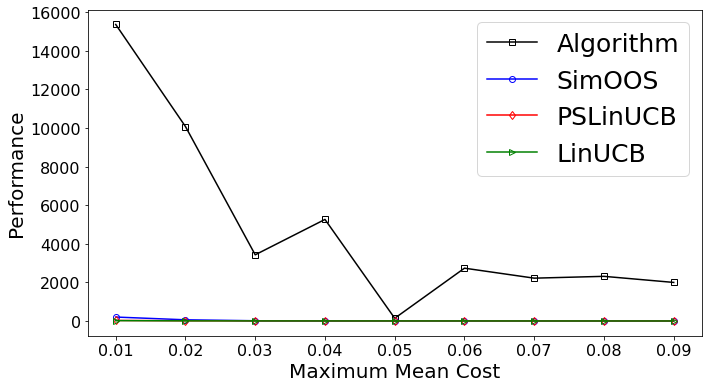

In [93]:
fig, ax = plt.subplots(1,1, figsize=(11, 6))

ind_to_params = {
        # ind: (mark, color)
        0: ('s', 'k'),
        1: ('o','blue'),
        2: ('d','r'),
        3: ('>','g'),
        4: ('x','olive'),
        5: ('^', 'm'),
        6: ('*', 'blue'),
    }

sorted_perf_dict = {
        k:v for k,v in sorted(performance.items(), key=lambda x: np.mean(x[1]), reverse=True)
    }

x = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]
for ind, (alg_name, alg_perf) in enumerate(list(sorted_perf_dict.items())[0:]):
    mark, color = ind_to_params[ind]
    ax.plot(x, alg_perf, label=alg_name.split()[0], marker=mark, fillstyle='none', color=color)
    
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
    
ax.set_xlabel('Maximum Mean Cost', fontsize=20)
ax.set_ylabel('Performance', fontsize=20)
    
plt.legend(prop={'size': 25});
# plt.savefig('performance_synthetic.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show();